configuration initial and review (execute first)this bloco initial recarrega the image medical of example (fatia of brain) and defines some variable and functions auxiliares that We will use in the examples of restoration of image. Let's review the model of degradation.

the code Funciona:* imports: loads the libraries necessary.* Loading of the image: loads `date.brain()` and seleciona the fatia, convertendo to `image_float` (0 the 1) and `image_ubyte (0 the 255)`. M and N are the dimensions original.* dimensions with Padding (P, Q): defines the dimensions to the DFT (generally the double of the original) to evitar error of enrolamento (wraparound).* `idft_process_extract`: function auxiliar crucial. Dada the DFT `G_centralizado` (with DC in the center), it:1. `ifftshift(G_centralizado)`: Desfaz the centralização, movendo the DC to the corner (0,0), that is the format expectsdo by `ifft2`.2. `ifft2(...)`: calculates the transform Inversa of Fourier discrete 2D.3. `.real`: gets the part real of the result (the image restaurada should be real).4. `img_padded_spatial[0:M_orig, 0:N_orig]`: Extrai the region correspondsnte to the original image, removendo the padding.5. `exposure.rescale_intensity(...)`: Normaliza the values of the image final to the interval [0,1] to correta visualization.* model of Degradação: Apresenta the equações in the domain spatial and of the frequency.

Imagem 'brain' (fatia 5) carregada para Cap. 5.

--- Modelo de Degradação/Restauração (Revisão) ---
Domínio Espacial: g(x,y) = h(x,y) * f(x,y) + η(x,y)
Domínio da Frequência: G(u,v) = H(u,v)F(u,v) + N(u,v)
f: original, h/H: degradação, η/N: ruído, g/G: observada


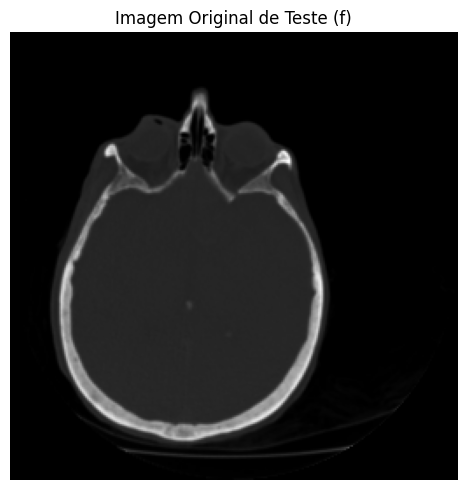

In [ ]:
# --- imports Necessary --- import numpy as np import matplotlib.pyplot as plt from skimage import date, img_as_float, img_as_ubyte, exposure, util, filters from scipy import ndimage from numpy.fft import fft2, ifft2, fftshift, ifftshift import time # Não will be used actively in the examples, but é good have  # --- load image Medical e defines variable Globais --- try:  brain_volume = date.brain()  if brain_volume.ndim == 3:  slice_index = brain_volume.shape[0] // 2  image_gray_orig_c5 = brain_volume[slice_index, :, :]  elif brain_volume.ndim == 2:  image_gray_orig_c5 = brain_volume  slice_index = "N/A (image 2D)"  else:  raise ValueError("format de image 'brain' not expectsdo.")  print(f"image 'brain' (fatia {slice_index if brain_volume.ndim == 3 else ''}) loaded to Cap. 5.") except Exception as e:  print(f"error ao to load 'brain': {e}. Usando 'camera' as fallback.")  image_gray_orig_c5 = date.camera()  image_float_c5 = img_as_float(image_gray_orig_c5.copy()) M_c5, N_c5 = image_float_c5.shape # dimensions original P_c5, Q_c5 = 2*M_c5, 2*N_c5 # dimensions with padding  # --- function Auxiliar to IDFT, extraction e Reescalonamento --- def idft_process_extract(G_centralizado, P_img, Q_img, M_orig, N_orig):  """applies ifftshift, ifft2, pega part real, remove padding e reescala."""  G_canto_dc = ifftshift(G_centralizado) # DC to the corner before of the IDFT  img_padded_spatial = ifft2(G_canto_dc).real  img_final = img_padded_spatial[0:M_orig, 0:N_orig] # Remove padding  return exposure.rescale_intensity(img_final, out_range=(0,1))  # --- function Auxiliar of Plotagem (already definida before, but repetindo to autonomy) --- def plot_images_c5(images, titles, cmaps=None, rows=1, cols=None, figsize=(15,5)):  num_images = len(images)  if cols is None:  cols = (num_images + rows - 1) // rows  fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)  axes_flat = axes.ravel()  if cmaps is None: cmaps_list = ['gray'] * num_images  elif isinstance(cmaps, str): cmaps_list = [cmaps] * num_images  else:  cmaps_list = list(cmaps)  if len(cmaps_list) < num_images: cmaps_list.extend(['gray']*(num_images-len(cmaps_list)))  for i in range(len(axes_flat)):  if i < num_images:  img, title, cmap = images[i], titles[i], cmaps_list[i]  axes_flat[i].imshow(img, cmap=cmap if img.ndim==2 else None); axes_flat[i].set_title(title); axes_flat[i].axis('off')  else: axes_flat[i].axis('off')  plt.tight_layout(); plt.show()  # model of Degradação (review Conceitual) print("\n--- model de Degradação/restoration (revision) ---") print("Domínio Espacial: g(x,y) = h(x,y) * f(x,y) + η(x,y)") print("Domínio of frequency: G(u,v) = H(u,v)F(u,v) + N(u,v)") print("f: original, h/H: degradation, η/N: ruído, g/G: observada")  plot_images_c5([image_float_c5], ["image Original de test (f)"], cmaps=['gray'], figsize=(5,5))

the output of text confirma the model of degradation.the image exibida is the fatia of resonance magnetic (or the image "camera" the fallback) that will be usada the image "original nítida" f(x,y) in our examples of simulation of degradation and restoration.

5.4 reduction of noise Periódico by Filtragem in the Domínio of the frequency

this example simula the addition of noise periodic (senoidal) the image and, in seguida, applies a filter Notch in the domain of the frequency to remove this noise. We will see the noise aparece in the spectrum and the filter Notch is projetado to atenuar these frequencies specific.

1. Addition of noise Periódico: one noise senoidal with `num_ciclos_ruido` to the long of the height `M_c5` of the image is adicionado to the `image_float_c5`. `np.cos` is used and the result is clipado to the interval [0,1].2. Preparo to DFT: the image noisy `img_com_ruido_periodico` is paddeada with zeros to the dimensions `P_c5, Q_c5`.3. DFT and Centralização: `Fp_noisy_notch_centralizada` is the DFT 2D of the image noisy paddeada, with the spectrum centralizado using `fftshift`.4. creation of the grids of frequency: `II_filt, JJ_filt` are matrices of indices. `U_map_filt, V_map_filt` are the coordinates of frequency (k_v,k_u) relative to the center `(P_c5/2,Q_c5/2)`. `U_map_filt` corresponds to the frequencies vertical of the image, and `V_map_filt` to the horizontal.5. Localização of the Picos of noise: `kv_pico_ruido` calculates the index of frequency vertical (in the axis `U_map_filt`) where the picos of noise aparecerão.6. Construção of the filter Notch: `H_filtro_notch` is inicializado the a filter passes-tudo (matrix of some). in seguida, to each pico of noise in `(U_map=pmkv_pico_ruido,V_map=0)`, one "vale" Gaussian (atenuação) is multiplicado in the filter. `sigma_notch` controla the width of that vale.7. application of the filter: `G_notch_filtrado_centralizado = H_filtro_notch * Fp_noisy_notch_centralizada`.8. IDFT and Pós-processamento: the function `idft_process_extract` is usada to get the image restaurada in the domain spatial.


--- Exemplo 5.4: Redução de Ruído Periódico ---


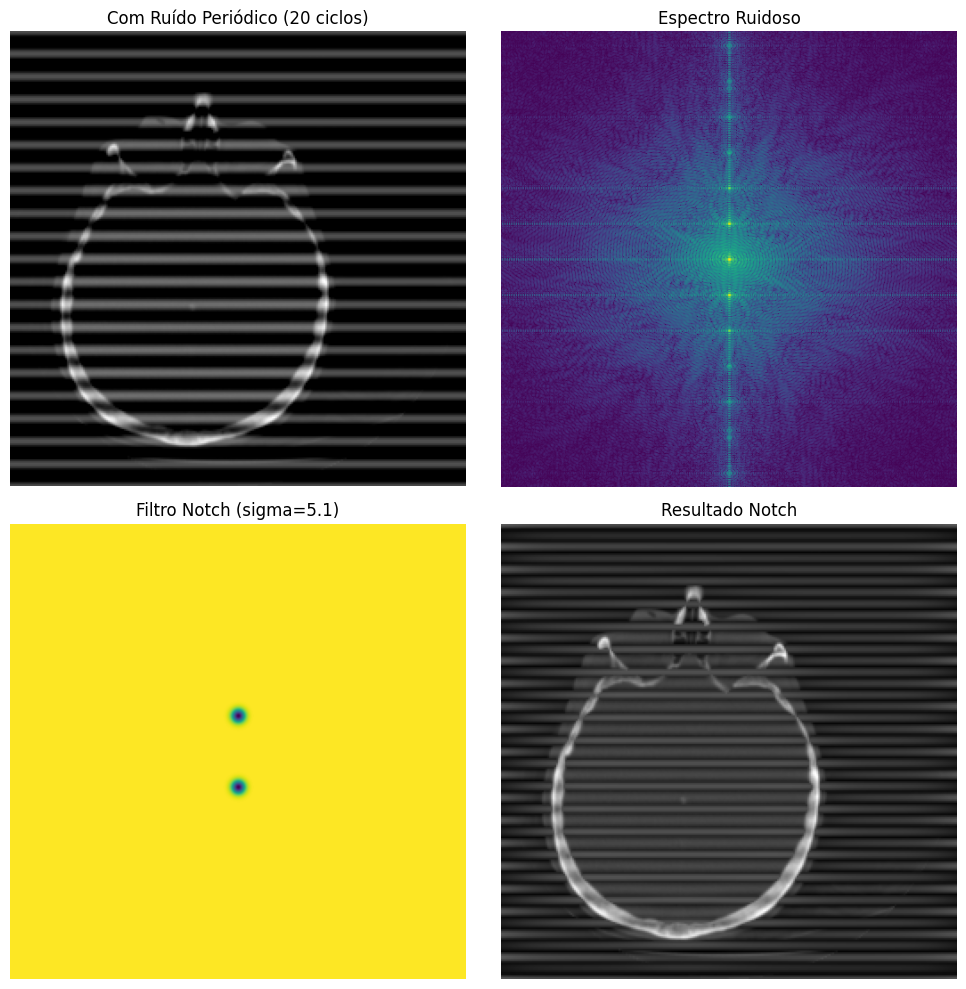

In [ ]:
# 5.4 reduction of noise Periódico  print("\n--- example 5.4: reduction de Ruído Periódico ---") # 1. add noise senoidal periodic to the original image img_com_ruido_periodico = image_float_c5.copy() num_ciclos_ruido = 20 # number of cycles of the noise in the vertical periodo_px_ruido_5_4 = M_c5 / num_ciclos_ruido amplitude_ruido_5_4 = 0.3 for r in range(M_c5):  img_com_ruido_periodico[r,:] += amplitude_ruido_5_4 * np.cos(2 * np.pi * r / periodo_px_ruido_5_4) img_com_ruido_periodico = np.clip(img_com_ruido_periodico, 0, 1)  # 2. Preparar image with noise to DFT (padding) fp_noisy_notch_pad = np.zeros((P_c5, Q_c5), dtype=float) fp_noisy_notch_pad[0:M_c5, 0:N_c5] = img_com_ruido_periodico  # 3. calculate the DFT e centralize the spectrum Fp_noisy_notch_centralizada = fftshift(fft2(fp_noisy_notch_pad)) espectro_ruidoso_vis = np.log1p(np.abs(Fp_noisy_notch_centralizada))  # 4. create grids of frequency (U to vertical, V to horizontal in the spectrum) II_filt_5_4, JJ_filt_5_4 = np.indices((P_c5, Q_c5)) U_map_filt_5_4 = II_filt_5_4 - P_c5//2 V_map_filt_5_4 = JJ_filt_5_4 - Q_c5//2  # 5. Localização of the picos of noise kv_pico_ruido_5_4 = num_ciclos_ruido * (P_c5 / M_c5) # position of the pico in the axis U_map  # 6. Construção of the filter Notch sigma_notch_5_4 = P_c5 * 0.01 # width of the notch (ex: 1% of P). adjustment if necessary. H_filtro_notch_5_4 = np.ones((P_c5, Q_c5), dtype=float)  if kv_pico_ruido_5_4 != 0:  # # Pico 1: (U_map = +kv_pico_ruido, V_map = 0)  D1_sq = (U_map_filt_5_4 - kv_pico_ruido_5_4)**2 + (V_map_filt_5_4 - 0)**2  H_filtro_notch_5_4 *= (1 - np.exp(-D1_sq / (2 * sigma_notch_5_4**2)))  # # Pico 2: (U_map = -kv_pico_ruido, V_map = 0)  D2_sq = (U_map_filt_5_4 + kv_pico_ruido_5_4)**2 + (V_map_filt_5_4 - 0)**2  H_filtro_notch_5_4 *= (1 - np.exp(-D2_sq / (2 * sigma_notch_5_4**2)))  # 7. apply the filter Notch G_notch_filtrado_centralizado = H_filtro_notch_5_4 * Fp_noisy_notch_centralizada  # 8. IDFT e pós-processamento img_filtered_com_notch = idft_process_extract(G_notch_filtrado_centralizado, P_c5, Q_c5, M_c5, N_c5)  # Visualization plot_images_c5([img_com_ruido_periodico, espectro_ruidoso_vis, H_filtro_notch_5_4, img_filtered_com_notch],  [f"with Ruído Periódico ({num_ciclos_ruido} cycles)", "spectrum Ruidoso", f"filter Notch (sigma={sigma_notch_5_4:.1f})", "result Notch"],  rows=2, cols=2, cmaps=['gray','viridis','viridis','gray'], figsize=(10,10))

* image with noise Periódico: the first image shows the fatia of the brain with lines horizontal (or one standard ondulatório) sobrepostas, resulting of the noise senoidal adicionado.* spectrum Ruidoso: the spectrum of magnitude of the image noisy. Além of the content normal of the image (energy concentrated in the center), you should see two points bright (picos) in the axis vertical (correspondsnte to the direction of the lines of the image), simetricamente above and below of the center. these are the components of frequency of the noise periodic.* filter Notch H(u,v): shows the function of transfer of the filter Notch. should be almost all branca (value 1, indicating that the maioria of the frequencies passes), with two small regions dark (value next of 0, indicating atenuação) exactly in the positions of the picos of noise identificados in the spectrum.* result Notch: the image after the application of the filter Notch. if the filter was well projetado and positioned, the lines of noise periodic should be significantmente reduzidas or eliminadas, with the minimum of degradation possible in the restante of the image. the sucesso depende of the precision of the localização of the picos and of the width (sigma_notch) of the filter.

5.5 Degradações linear and Invariantes to the position

this section is mainly conceptual and serve of base to the filters of restoration that lidam with borramento. Não there will be an example of code that "implemente" this section, but sim the reafirmação of the model.

the code Funciona (Conceitual):Relembra that if the degradation h(x,y) is linear and Invariante to the position (LPI), the image degradada g(x,y) (without noise) is the convolution $f(x,y) * h(x,y)$.in the domain of the frequency, This if becomes the multiplication G(u,v)=F(u,v)H(u,v).the maioria of the filters of restoration that We will see (Inverso, Wiener, Mínimos square Restritos) assume this nature LPI of the degradation.

In [ ]:
# 5.5 Degradações linear e Invariantes à position (Conceitual) print("\n--- section 5.5: Degradações Lineares e Invariantes à position (LPI) ---") print("Esta section é fundamentalmente teórica, estabelecendo that if a degradation h(x,y) é LPI,") print("then g(x,y) = h(x,y) * f(x,y) (without ruído).") print("in domain of frequency: G(u,v) = H(u,v)F(u,v).") print("Este model é a base to os filters de deconvolução that veremos a seguir.") # Não há one code specific to "run" here, apenas to fixar the concept. 


--- Seção 5.5: Degradações Lineares e Invariantes à Posição (LPI) ---
Esta seção é fundamentalmente teórica, estabelecendo que se a degradação h(x,y) é LPI,
então g(x,y) = h(x,y) * f(x,y) (sem ruído).
No domínio da frequência: G(u,v) = H(u,v)F(u,v).
Este modelo é a base para os filtros de deconvolução que veremos a seguir.


5.6 Estimando the function of Degradação H

to restaurar the image of the degradation the borramento, we need of the estimate of the function of degradation H(u,v) (or your PSF h(x,y)). this section discusses methods to get H. Let's simular the creation of the PSF of borramento by movement and your correspondsnte H(u,v).

1. simulation of PSF of movement:* `L_mov = 20`: length of the borramento by movement in pixels.* `theta_mov = 0`: angle of the movement (0 degrees = horizontal).* `psf_movimento = np.zeros((L_mov, L_mov))`: creates the small image to the PSF.* `cv2.line(...)`: Desenha the line branca in the `psf_movimento` to simular the trait of movement. the line is normalizada to that the soma of the PSF whether 1.2. calculation of H(u,v):* the `psf_movimento` is paddeada to the size `(P_c5, Q_c5)`.* your origin (canto upper left) is implicitamente the point of reference.* `H_movimento = fftshift(fft2(psf_movimento_padded))`: calculates the DFT 2D of the PSF paddeada and centraliza the spectrum for visualization. this `H_movimento` is the function of transfer of the degradation by movement.3. simulation of the Degradação:* `F_img_original_padded_cent = fftshift(fft2(fp_para_filtering))`: gets the DFT of the original image paddeada and centralizada (reutilizando `fp_para_filtering` of the config initial if `image_float_c5` not mudou).* `G_degradada_mov_cent = F_img_original_padded_cent * ifftshift(H_movimento)`: applies the degradation in the domain of the frequency. Note the ifftshift(H_movimento): if F is centralizada and H also is defined of shape centralizada (DC in the middle), the multiplication is direct. if H was calculated with DC in the corner (the `fft2(psf_padded)` without shift initial of the psf), and F is centralizada, one of the two needs be shiftado to align the origins before of the multiplication. the practice more common is have F and H ambos centralizados to the multiplication.* the image degradada `img_degradada_mov` is obtida by the IDFT.

In [ ]:
# M_c5, N_c5 are the dimensions of the original image (ex: image_float_c5) # P_c5, Q_c5 are the dimensions with padding (ex: 2*M_c5, 2*N_c5)  # 1. creates the matrix of zeros with the dimensions of padding (P_c5 x Q_c5) fp_para_filtering = np.zeros((P_c5, Q_c5), dtype=float)  # 2. Copia the original image to the corner upper left of this matrix larger fp_para_filtering[0:M_c5, 0:N_c5] = image_float_c5


--- Exemplo 5.6: Simulação de uma PSF de Movimento e seu H(u,v) ---


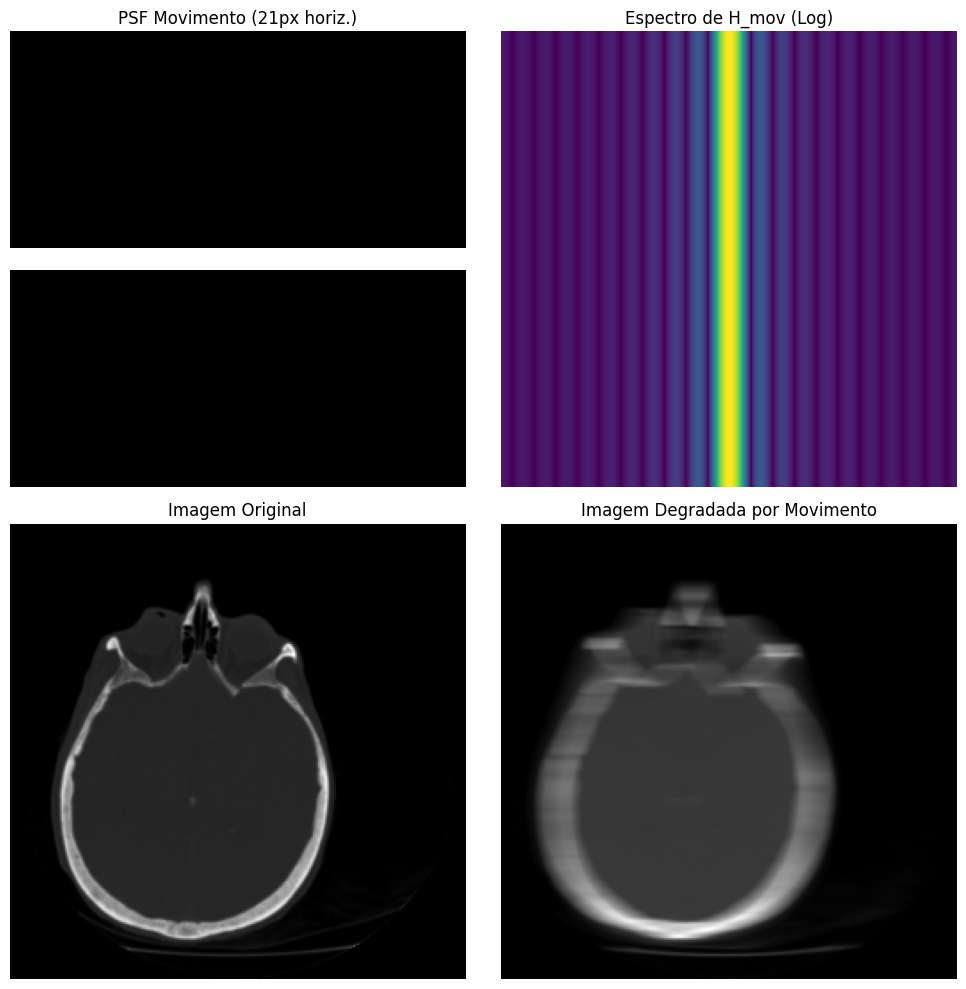

In [ ]:
# 5.6 Estimando the function of Degradação H  print("\n--- example 5.6: Simulação de uma PSF de movement e seu H(u,v) ---") # 1. Simular the PSF of borramento by movement horizontal L_mov = 21 # length of the movement (pixels), ímpar to have one center psf_movimento = np.zeros((L_mov, L_mov), dtype=float) # creates the line horizontal in the center of the PSF psf_movimento[L_mov//2, :] = 1.0 psf_movimento /= np.sum(psf_movimento) # Normaliza the PSF  # 2. calculate H(u,v) of the PSF (with padding e centralização for visualization) psf_movimento_padded = np.zeros((P_c5, Q_c5), dtype=float) # Colocar the PSF in the corner upper left to DFT (origin of the convolution) # in the entanto, to that H(u,v) whether real after the shift (if the PSF for simétrica), # the PSF should estar centralizada in the array before of the fftshift(fft2(...)) # or, mais simple, coloque the PSF in the corner e shifte H(u,v) for visualization. # to the calculation of the degradation G = FH, H should estar in the same order of F. # if F has DC in the corner, H also. if F has DC in the center, H also.  # let's standardize: PSF with origin in the corner (0,0) of the array PxQ # the "center" of the PSF (pixel L_mov//2, L_mov//2) ficará in (0,0) of the array PxQ after roll. # or, simply, coloque the psf in the corner (0,0) of the array PxQ. # psf_movimento_padded[0:L_mov, 0:L_mov] = psf_movimento # PSF in the corner  # to that the convolution in the domain of the frequency G = F*H funcione correctly, # H should be the DFT of the PSF h(x,y) with the origin of h(x,y) in the pixel (0,0) of the matrix. # the PSF that we create (psf_movimento) has your "center" in L_mov//2. # let's colocar the center of the psf_movimento in (0,0) of the matrix psf_movimento_padded, # permitindo that it "enrole" (wraparound), What is correto to DFT/convolution. psf_movimento_padded_rolled = np.zeros((P_c5, Q_c5), dtype=float) r_offset, c_offset = L_mov//2, L_mov//2 for r_psf in range(L_mov):  for c_psf in range(L_mov):  # # Mapeia (r_psf, c_psf) of the psf to positions in the matrix PxQ with (0,0) the center of the psf  # # (r_psf - r_offset) mod P_c5 etc.  idx_r_pad = (r_psf - r_offset + P_c5) % P_c5  idx_c_pad = (c_psf - c_offset + Q_c5) % Q_c5  psf_movimento_padded_rolled[idx_r_pad, idx_c_pad] = psf_movimento[r_psf, c_psf]  H_movimento_nao_centralizado = fft2(psf_movimento_padded_rolled) # DC in the corner H_movimento_centralizado_vis = fftshift(H_movimento_nao_centralizado) # DC in the center for visualization  # 3. Simular the Degradação in the original image # fp_para_filtering was definida in 4.7/4.8 the image_float paddeada F_img_original_padded_nao_centralizado = fft2(fp_para_filtering) # DC in the corner  # G = F * H (ambos with DC in the corner) G_degradada_mov_nao_centralizado = F_img_original_padded_nao_centralizado * H_movimento_nao_centralizado img_degradada_mov_padded = ifft2(G_degradada_mov_nao_centralizado).real img_degradada_mov = exposure.rescale_intensity(img_degradada_mov_padded[0:M_c5, 0:N_c5], out_range=(0,1))  # Visualization plot_images_c5([psf_movimento, np.log1p(np.abs(H_movimento_centralizado_vis)), image_float_c5, img_degradada_mov],  [f"PSF movement ({L_mov}px horiz.)", "spectrum de H_mov (Log)", "image Original", "image Degradada by movement"],  rows=2, cols=2, cmaps=['gray','viridis','gray','gray'], figsize=(10,10))

Interpretando the results (5.6):* PSF movement: the first image shows the Point Spread Function (PSF) that simula the borramento by movement horizontal. is the line horizontal of pixels brancos.* spectrum of H_mov (Log): the spectrum of magnitude of the H(u,v) correspondsnte to the PSF of movement. you will see one standard característico: the line vertical bright in the center (component DC) and "sincs" perpendicular the this line. the zeros of the function sinc (lines dark) indicate frequencies that are completely atenuadas by the degradation by movement.* original image: our image of reference.* image Degradada by movement: the original image after the convolution with the PSF of movement (realizada via multiplication in the domain of the frequency). the image aparecerá borrada in the direction horizontal, simulando the effect of movement of the câmera or of the object during the exposição.

5.7 Filtragem Inversa

the filtering inversa tenta reverter the degradation dividindo the DFT of the image degradada by the DFT of the function of degradation (H(u,v)). Demonstraremos the problem of the amplificação of noise and the shape truncada of filtering inversa.

1. image Degradada and H(u,v): Reutilizamos `img_degradada_mov` and `H_movimento_nao_centralizado` of the example previous. one little of noise Gaussian is adicionado to the image degradada to simular the situation more realista.2. DFT of the image Degradada Ruidosa: `G_degradada_noisy_nao_cent` is the DFT of the image degradada with noise (DC in the corner).3. Filtragem Inversa direct:* `F_hat_inversa_direta = G_degradada_noisy_nao_cent / (H_movimento_nao_centralizado + epsilon)`: Realiza the division. `epsilon` is one value very small to evitar division by zero exato, but not resolve the problem of the amplificação where H is small.* the `image img_rest_inversa_direta` is obtida by the IDFT.4. Filtragem Inversa Truncada:* `H_abs = np.abs(H_movimento_nao_centralizado)`* `threshold_H = H_abs.max() * 0.05`: defines a threshold (ex: 5% of the magnitude máxima of H).* creates the mask `mask_H_valido` where ∣H(u,v)∣ is above of the threshold.* `F_hat_inversa_trunc = np.where(mask_H_valido, G_degradada_noisy_nao_cent / (H_movimento_nao_centralizado + epsilon), 0)`: applies the division only where H is válido; if contrário, zera the coeficiente.* the `image img_rest_inversa_trunc` is obtida by the IDFT.


--- Exemplo 5.7: Filtragem Inversa ---


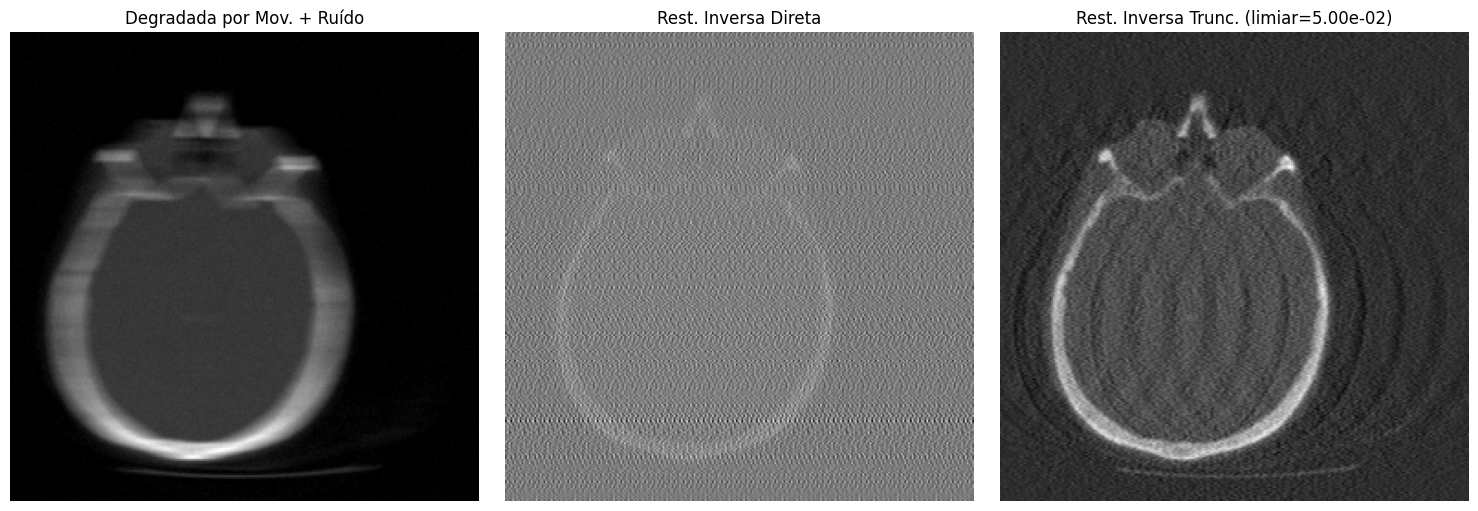

In [ ]:
# 5.7 Filtragem Inversa  print("\n--- example 5.7: Filtragem Inversa ---") # use the image degradada by movement e H(u,v) of the example previous (5.6) # Assume-if that the variable image_float_c5, M_c5, N_c5, P_c5, Q_c5, # H_movimento_nao_centralizado (DFT of the PSF of movement, DC in the corner), # e img_degradada_mov (image borrada without noise additional) are definidas the partir of the example 5.6.  # add one pouco of noise to the image degradada by movement sigma_ruido_inv_5_7 = 0.01 img_degradada_mov_noisy_5_7 = util.random_noise(img_degradada_mov, mode='gaussian', var=sigma_ruido_inv_5_7**2) img_degradada_mov_noisy_5_7 = np.clip(img_degradada_mov_noisy_5_7, 0, 1)  # DFT of the image degradada e noisy (with padding implícito in the dimensions PxQ) fp_degradada_noisy_5_7 = np.zeros((P_c5, Q_c5)) fp_degradada_noisy_5_7[0:M_c5, 0:N_c5] = img_degradada_mov_noisy_5_7 G_degradada_noisy_nao_cent_5_7 = fft2(fp_degradada_noisy_5_7) # DC in the corner  # defines epsilon epsilon = 1e-8 # small constant to evitar division by zero  # 1. Filtragem Inversa direct # H_movimento_nao_centralizado é the DFT of the PSF (HxQ) with DC in the corner F_hat_inversa_direta_nao_cent_5_7 = G_degradada_noisy_nao_cent_5_7 / (H_movimento_nao_centralizado + epsilon) img_rest_inversa_direta_padded_5_7 = ifft2(F_hat_inversa_direta_nao_cent_5_7).real img_rest_inversa_direta_5_7 = exposure.rescale_intensity(img_rest_inversa_direta_padded_5_7[0:M_c5, 0:N_c5], out_range=(0,1))  # 2. Filtragem Inversa Truncada (Pseudo-inversa) H_abs_nao_cent_5_7 = np.abs(H_movimento_nao_centralizado) threshold_truncamento_H_5_7 = H_abs_nao_cent_5_7.max() * 0.05 # Ex: 5% of the maximum of |H|  F_hat_inversa_trunc_nao_cent_5_7 = np.zeros_like(G_degradada_noisy_nao_cent_5_7, dtype=complex) mascara_H_valido_5_7 = H_abs_nao_cent_5_7 > threshold_truncamento_H_5_7  # Evitar warning of division by zero same with epsilon, checando the mask first # e ensuring that H_movimento_nao_centralizado[mascara_H_valido_5_7] not whether zero. # the epsilon already helps, but the checagem é mais segura. H_valido = H_movimento_nao_centralizado[mascara_H_valido_5_7] G_valido = G_degradada_noisy_nao_cent_5_7[mascara_H_valido_5_7] F_hat_inversa_trunc_nao_cent_5_7[mascara_H_valido_5_7] = G_valido / (H_valido + epsilon)   img_rest_inversa_trunc_padded_5_7 = ifft2(F_hat_inversa_trunc_nao_cent_5_7).real img_rest_inversa_trunc_5_7 = exposure.rescale_intensity(img_rest_inversa_trunc_padded_5_7[0:M_c5, 0:N_c5], out_range=(0,1))  # Visualization plot_images_c5([img_degradada_mov_noisy_5_7, img_rest_inversa_direta_5_7, img_rest_inversa_trunc_5_7],  ["Degradada by Mov. + Ruído", "Rest. Inversa Direta", f"Rest. Inversa Trunc. (threshold={threshold_truncamento_H_5_7:.2e})"],  cmaps=['gray','gray','gray'])

* Degradada by Mov. + noise: the image of input to the restoration, showing the borramento horizontal and the noise Gaussian adicionado.* Rest. Inversa direct: this result probably will be very ruim and dominado by the noise. in the frequencies where H(u,v) (especially H_movimento) was small (the "zeros" of the function sinc in the spectrum of H), the termo of noise N(u,v)/H(u,v) was massivamente amplificado, becomesndo the image restaurada inutilizável.* Rest. Inversa Truncada: this version should be better that the inversa direct. to the not tentar restaurar (or zerar) the components of frequency where H(u,v) is very weak, the amplificação extrema of the noise is evitada nessas regions. in the entanto, the image still can have some noise amplificado in the frequencies where the inversão was permitida, and the details correspondsntes to the frequencies truncadas will be perdidos. the result can be one compromisso, talvez less ruidoso, but still with artifacts or perda of nitidez. the choose of the threshold_truncamento_H is crítica.

5.8 Filtragem of Wiener

the filter of Wiener is the abordagem statistical to restoration that minimiza the error quadrático médio between the original image and the restaurada. it leva in conta both the function of degradation H(u,v) the spectra of power (or the estimate deles) of the original image and of the noise. Espera-if that produza results betteres that the filtering inversa, especially in the presence of noise.

1. inputs:* `G_degradada_noisy_nao_cent`: DFT of the image degradada and noisy (DC in the corner).* `H_movimento_nao_centralizado`: DFT of the PSF of movement (DC in the corner).2. parameter K (approximation of S_eta/S_f):* in vez of estimate the spectra of power complete of the noise (S_eta) and of the original image (S_f), we use the approximation where the reason S_eta(u,v)/S_f(u,v) is considerada the constant K.* `K_wiener` is this parameter. one value smaller of K if aproxima of the filtering inversa (more aguçamento, more noise); one value larger increases the suppression of noise (more smoothing).3. calculation of the filter of Wiener and application:* `H_conj = np.conj(H_movimento_nao_centralizado)`: Conjugado complex of H.* `H_mag_sq = np.abs(H_movimento_nao_centralizado)**2`: Magnitude to the square of H.* `Filtro_Wiener = H_conj / (H_mag_sq + K_wiener)`: this is the part of the filter of Wiener* `F_hat_wiener_nao_cent = Filtro_Wiener * G_degradada_noisy_nao_cent`: applies the filter.4. IDFT and Pós-processamento: `idft_process_extract` converte of return to the domain spatial, remove padding and normaliza.


--- Exemplo 5.8: Filtragem de Wiener ---


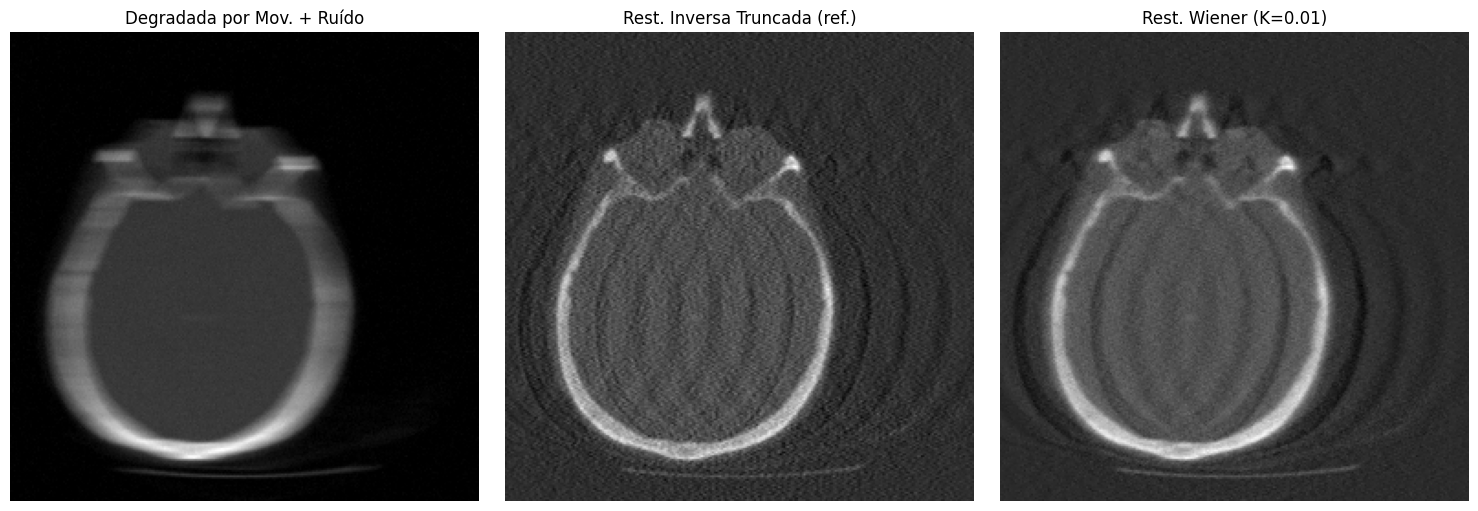

In [ ]:
# 5.8 Filtragem of Wiener  print("\n--- example 5.8: Filtragem de Wiener ---") # Reutilizar G_degradada_noisy_nao_cent_5_7 (DFT of the image degradada+noise, DC in the corner) of the example 5.7 # Reutilizar H_movimento_nao_centralizado (DFT of the PSF, DC in the corner) of the example 5.6  # defines epsilon epsilon = 1e-8 # small constant to evitar division by zero  # parameter K to the filter of Wiener (approximation of Sn(u,v)/Sf(u,v)) K_wiener_5_8 = 0.01 # adjust este value experimentalmente (ex: 0.1, 0.01, 0.001)  # components of the filter of Wiener (Eq. 5.8-7: F_hat = [H* / (|H|^2 + Sn/Sf)] * G ) # Sn/Sf é aproximado by K. H_conj_wiener_5_8 = np.conj(H_movimento_nao_centralizado) H_mag_sq_wiener_5_8 = np.abs(H_movimento_nao_centralizado)**2  # the termo K_wiener_5_8 in the denominador previne division by zero if H_mag_sq_wiener_5_8 for zero. Filtro_Wiener_parte_ativa_5_8 = H_conj_wiener_5_8 / (H_mag_sq_wiener_5_8 + K_wiener_5_8 + epsilon) F_hat_wiener_nao_cent_5_8 = Filtro_Wiener_parte_ativa_5_8 * G_degradada_noisy_nao_cent_5_7  # IDFT, remove padding e reescalar # (Assumindo that idft_process_extract was definida in the cell of configuration initial) img_rest_wiener_padded_5_8 = ifft2(F_hat_wiener_nao_cent_5_8).real img_rest_wiener_5_8 = exposure.rescale_intensity(img_rest_wiener_padded_5_8[0:M_c5, 0:N_c5], out_range=(0,1))  # Visualization # Reutilizar img_rest_inversa_trunc_5_7 to comparison plot_images_c5([img_degradada_mov_noisy_5_7, img_rest_inversa_trunc_5_7, img_rest_wiener_5_8],  ["Degradada by Mov. + Ruído", "Rest. Inversa Truncada (ref.)", f"Rest. Wiener (K={K_wiener_5_8})"],  cmaps=['gray','gray','gray'])

* Degradada by Mov. + noise: the image of input.* Rest. Inversa Truncada (ref.): the result of the filtering inversa truncada of the example previous, to comparison.* Rest. Wiener: the image restaurada using the filter of Wiener.comparison: the result of the filter of Wiener should be visivelmente better of the that the filtering inversa direct and, many vezes, also better that the inversa truncada.* effect of K:if K_wiener for well escolhido, there will be one good equilibrium between the removal of the borramento (deconvolução) and the suppression of the noise. the image parecerá more nítida that the degradada, but with less noise amplificado of the that in the filtering inversa.if K_wiener for very small, the result if aproximará of the filtering inversa and the noise still will be one problem.if K_wiener for very large, the filter if becomesrá very conservador, resultando in excessiva smoothing (pouca deconvolução) and removal of details junto with the noise.* the filter of Wiener not introduz the same type of "corte" abrupto of frequencies that the inversa truncada, levando the results generally more smooth and with less artifacts.